## Connecting with Kaggle and obtaining the necessary data.
[https://www.kaggle.com/CooperUnion/anime-recommendations-database](https://)

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chandakanish7","key":"a962189dd5db9623b2973142224dc3f5"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d CooperUnion/anime-recommendations-database

 68% 17.0M/25.0M [00:01<00:00, 10.2MB/s]
100% 25.0M/25.0M [00:01<00:00, 15.7MB/s]


In [5]:
!mkdir Dataset

In [6]:
!unzip /content/anime-recommendations-database.zip

Archive:  /content/anime-recommendations-database.zip
  inflating: anime.csv               
  inflating: rating.csv              


In [7]:
!mv /content/anime.csv /content/Dataset

In [8]:
!mv /content/rating.csv /content/Dataset

In [9]:
!pip install modin[ray]

     |████████████████████████████████| 389kB 2.8MB/s 
     |████████████████████████████████| 21.9MB 1.2MB/s 
     |████████████████████████████████| 2.9MB 50.5MB/s 
     |████████████████████████████████| 71kB 9.7MB/s 
     |████████████████████████████████| 1.2MB 45.4MB/s 
     |████████████████████████████████| 153kB 50.6MB/s 
     |████████████████████████████████| 266kB 53.8MB/s 
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3161 sha256=e74d07aaad75fb1039f3dc67fe3cfd2ddaf719a562083f9e1c6928de398ddf6b
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built idna-ssl


## Necessary Imports

In [10]:
# import commands here.
import modin.pandas as pd
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import chardet
import numpy as np

%matplotlib inline

In [12]:
# Reading Data.
anime_data = pd.read_csv('/content/Dataset/anime.csv')
rating_data = pd.read_csv('/content/Dataset/rating.csv')

In [13]:
# Checking anime data.
print(('-'*50)+'ANIME DATA'+('-'*50))
print('\n')
print(('-'*50)+'COLUMN INFO'+('-'*50))
print(anime_data.columns)
print('\n')
print(('-'*50)+'ANIME DATA (HEAD)'+('-'*45))
print(anime_data.head())
print(('-'*50)+'ANIME DATA (TAIL)'+('-'*45))
print(anime_data.tail())
print(('-'*50)+'ANIME DATA (DESCRIBE)'+('-'*45))
print(anime_data.describe())
print(('-'*50)+'ANIME DATA (INFO)'+('-'*45))
print(anime_data.info())

--------------------------------------------------ANIME DATA--------------------------------------------------


--------------------------------------------------COLUMN INFO--------------------------------------------------
Index(['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members'], dtype='object')


--------------------------------------------------ANIME DATA (HEAD)---------------------------------------------
   anime_id                              name  ... rating members
0     32281                    Kimi no Na wa.  ...   9.37  200630
1      5114  Fullmetal Alchemist: Brotherhood  ...   9.26  793665
2     28977                          Gintama°  ...   9.25  114262
3      9253                       Steins;Gate  ...   9.17  673572
4      9969                     Gintama&#039;  ...   9.16  151266

[5 rows x 7 columns]
--------------------------------------------------ANIME DATA (TAIL)---------------------------------------------
       anime_id  ... members
12289 

In [14]:
# Checking rating data.
print(('-'*50)+'RATING DATA'+('-'*50))
print('\n')
print(('-'*50)+'COLUMN INFO'+('-'*50))
print(rating_data.columns)
print('\n')
print(('-'*50)+'RATING DATA (HEAD)'+('-'*45))
print(rating_data.head())
print(('-'*50)+'RATING DATA (TAIL)'+('-'*45))
print(rating_data.tail())
print(('-'*50)+'RATING DATA (DESCRIBE)'+('-'*45))
print(rating_data.describe())
print(('-'*50)+'RATING DATA (INFO)'+('-'*45))
print(rating_data.info())

--------------------------------------------------RATING DATA--------------------------------------------------


--------------------------------------------------COLUMN INFO--------------------------------------------------
Index(['user_id', 'anime_id', 'rating'], dtype='object')


--------------------------------------------------RATING DATA (HEAD)---------------------------------------------
   user_id  anime_id  rating
0        1        20      -1
1        1        24      -1
2        1        79      -1
3        1       226      -1
4        1       241      -1
--------------------------------------------------RATING DATA (TAIL)---------------------------------------------
         user_id  anime_id  rating
7813732    73515     16512       7
7813733    73515     17187       9
7813734    73515     22145      10
7813735    73516       790       9
7813736    73516      8074       9
--------------------------------------------------RATING DATA (DESCRIBE)-------------------------------

## Data cleaning

In [18]:
def clean_anime_name(row):
    try:
        return re.sub("[^a-zA-Z0-9 ]","",row['name']).lower()
    except:
        print("Error:",row['name'])

def clean_anime_genre(row):
    try:
        return re.sub(',','',row['genre']).lower()
    except:
        print("Error:",row['genre'])

def clean_type(row):
    return row['type'].lower()

def clean_episodes(row):
    try:
        return re.sub('Unknown','',row['episodes'])
    except:
        print("Error:",row['episodes'])

In [19]:
anime_data['cleaned_name'] = anime_data.apply(clean_anime_name,axis = 1)

In [20]:
anime_data['genre'] = anime_data['genre'].fillna('')
anime_data['cleaned_genre'] = anime_data.apply(clean_anime_genre,axis = 1)

In [21]:
anime_data['type'] = anime_data['type'].fillna('')
anime_data['cleaned_type'] = anime_data.apply(clean_type,axis = 1)

In [22]:
anime_data['cleaned_episodes'] = anime_data.apply(clean_episodes,axis = 1)

In [23]:
anime_data.columns

Index(['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members',
       'cleaned_name', 'cleaned_genre', 'cleaned_type', 'cleaned_episodes'],
      dtype='object')

In [24]:
selected_features = ['cleaned_name', 'cleaned_genre','cleaned_type', 'cleaned_episodes']

## Helper Functions.

In [25]:
def get_anime_id_from_name(name):
    return anime_data[anime_data.cleaned_name == name]['anime_id'].values[0]

In [26]:
def get_name_from_anime_id(anime_id):
    try:
        return anime_data[anime_data.anime_id == anime_id]['cleaned_name'].values[0]
    except:
        pass

In [27]:
def combine_features(row):
    return row['cleaned_name']+" "+row['cleaned_genre']+" "+row['cleaned_type']+" "+row['cleaned_episodes']

In [28]:
anime_data['combined_features'] = anime_data.apply(combine_features,axis = 1)

In [29]:
len(rating_data.anime_id.unique())

11200

In [30]:
len(anime_data.anime_id.unique())

12294

## Data Cleaning (Continue)

In [31]:
# checking how many user
user_count_per_anime_df = rating_data.groupby('anime_id')['user_id'].nunique().reset_index(name='user_IdCount')

In [32]:
user_IdCount = user_count_per_anime_df.sort_values(by = ['user_IdCount'],ascending=False)

To request implementation, send an email to feature_requests@modin.org.


In [33]:
user_IdCount.shape

(11200, 2)

In [34]:
# Filtering users who have rated more than or equal to 90 movies.
ratings_f = rating_data.groupby('user_id').filter(lambda x:len(x)>=90)
# After filtering ,
anime_list_rating = ratings_f.anime_id.unique().tolist()

In [35]:
(len(ratings_f.anime_id.unique())/len(anime_data.anime_id.unique()))*100

91.07694810476656

In [36]:
(len(ratings_f.user_id.unique())/len(rating_data.user_id.unique()))*100

36.94756172209753

In [37]:
len(anime_list_rating)

11197

In [38]:
# filter the anime dataframe
anime_data = anime_data[anime_data['anime_id'].isin(anime_list_rating)]

In [39]:
anime_data.shape

(11194, 12)

In [40]:
filtered_anime_id = set(anime_list_rating)-set(anime_data.anime_id.tolist())

In [41]:
filtered_anime_id = list(filtered_anime_id)

In [42]:
ratings_f.drop(ratings_f[ratings_f['anime_id'].isin(filtered_anime_id)].index,inplace=True)

In [43]:
ratings_f.shape

(6332041, 3)

In [44]:
ratings_f.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [45]:
ratings_f1 = pd.merge(anime_data[['anime_id']],ratings_f,on='anime_id',how='right')

In [46]:
ratings_f1.head()

,anime_id,user_id,rating
0,32281,99,5
1,32281,152,10
2,32281,244,10
3,32281,271,10
4,32281,398,10


In [47]:
ratings_f1.shape

(6332041, 3)

In [48]:
# checking how many user
user_count_per_anime_df_2 = ratings_f1.groupby('anime_id')['user_id'].nunique().reset_index(name='user_IdCount')
user_IdCount_2 = user_count_per_anime_df_2.sort_values(by = ['user_IdCount'],ascending=False)

In [49]:
print(user_IdCount_2.shape)
print(anime_data.shape)

(11194, 2)
(11194, 12)


In [50]:
anime_data_user_counts_df = pd.merge(user_IdCount,anime_data,on = 'anime_id',how='left')

In [51]:
anime_data_user_counts_df.head()

,anime_id,user_IdCount,name,genre,type,episodes,rating,members,cleaned_name,cleaned_genre,cleaned_type,cleaned_episodes,combined_features
0,1535,39340,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917,death note,mystery police psychological supernatural thri...,tv,37,death note mystery police psychological supern...
1,11757,30582,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100,sword art online,action adventure fantasy game romance,tv,25,sword art online action adventure fantasy game...
2,16498,29583,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229,shingeki no kyojin,action drama fantasy shounen super power,tv,25,shingeki no kyojin action drama fantasy shoune...
3,1575,27717,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151,code geass hangyaku no lelouch,action mecha military school sci-fi super power,tv,25,code geass hangyaku no lelouch action mecha mi...
4,226,27506,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,...",TV,13,7.85,623511,elfen lied,action drama horror psychological romance sein...,tv,13,elfen lied action drama horror psychological r...


In [52]:
!mkdir Database_Files

In [53]:
anime_data_user_counts_df.to_csv('/content/Database_Files/new_anime_data.csv',columns = anime_data_user_counts_df.columns)

In [54]:
anime_data.to_csv('/content/Database_Files/anime_data_2.csv',columns = anime_data.columns)

## Content Based Filtering

In [55]:
tfidf = TfidfVectorizer(stop_words = 'english')
tfidf_matrix = tfidf.fit_transform(anime_data.combined_features)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(),anime_data.index.tolist())
print(tfidf_df.shape)

(11194, 11909)


In [56]:
cv = CountVectorizer()
cv_matrix = cv.fit_transform(anime_data.combined_features)
cv_df = pd.DataFrame(cv_matrix.toarray(),anime_data.index.tolist())
print(cv_df.shape)

(11194, 12034)


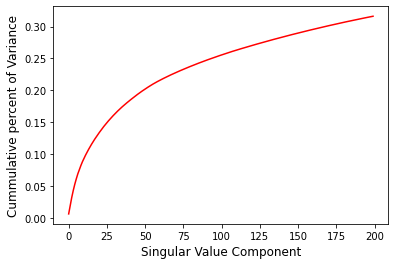

In [57]:
svd_2 = TruncatedSVD(n_components=200)
latent_matrix_2 = svd_2.fit_transform(tfidf_df)
# Plot var explained
explained_2 = svd_2.explained_variance_ratio_.cumsum()
plt.plot(explained_2,'-',ms=16,color='red')
plt.xlabel('Singular Value Component',fontsize = 12)
plt.ylabel('Cummulative percent of Variance',fontsize=12)
plt.show()

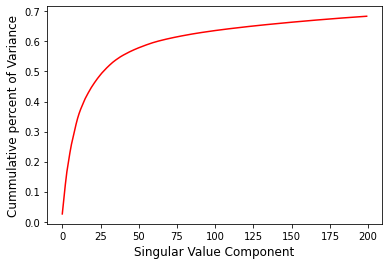

In [58]:
svd_3 = TruncatedSVD(n_components=200)
latent_matrix_3 = svd_3.fit_transform(cv_df)
# Plot var explained
explained_3 = svd_3.explained_variance_ratio_.cumsum()
plt.plot(explained_3,'-',ms=16,color='red')
plt.xlabel('Singular Value Component',fontsize = 12)
plt.ylabel('Cummulative percent of Variance',fontsize=12)
plt.show()

In [59]:
n = 200
latent_matrix_1_df = pd.DataFrame(latent_matrix_3[:,0:n],index = anime_data.name.tolist())

In [60]:
latent_matrix_1_df.head()

,0,1,2,3,4,5,6,7,8,9,10,189,190,191,192,193,194,195,196,197,198,199
Kimi no Na wa.,1.058104,0.040561,0.864502,0.538268,0.245810,0.600721,-0.019463,-0.341587,-0.648448,1.150391,0.410443,0.010849,0.036608,-0.054400,-0.033814,0.022506,0.024854,-0.047631,-0.022580,-0.034458,0.001556,0.002385
Fullmetal Alchemist: Brotherhood,1.542666,-0.329396,-0.606532,0.333287,-0.904849,0.472320,-0.358157,-0.082222,1.075165,0.483684,0.367631,0.048576,0.010109,0.025449,0.014660,0.030498,0.007028,0.018551,-0.003846,0.025767,-0.023352,0.010661
Gintama°,1.776551,-0.348643,-1.263422,-0.122628,-0.016022,-0.322650,0.101176,-0.012099,-0.342129,-0.022864,-0.521885,0.010157,-0.019270,-0.022604,0.007018,0.005950,0.011144,-0.030384,-0.033936,0.002029,-0.002765,-0.021732
Steins;Gate,0.796444,-0.386649,-1.022311,-0.121319,0.248278,0.439494,0.175500,-0.005840,-0.441359,-0.451495,0.165321,-0.002789,0.013858,0.000475,-0.004145,-0.021263,-0.002977,0.005250,0.015774,-0.003454,0.027109,-0.004257
Gintama&#039;,1.775320,-0.347800,-1.262557,-0.122920,-0.017477,-0.318560,0.099490,-0.011996,-0.341934,-0.024366,-0.520242,0.004285,-0.013369,-0.010358,-0.004369,0.003746,-0.002107,-0.022421,-0.029876,-0.003180,0.008867,-0.011583


In [61]:
latent_matrix_1_df.to_csv('/content/Database_Files/content_based_latent_matrix.csv')

## Colaborative Filtering

In [62]:
ratings_f2 = ratings_f1.reset_index().pivot_table(index='anime_id',columns='user_id',values='rating',fill_value=0)

In [63]:
ratings_f2 = ratings_f2.replace(to_replace=-1,value=0)

In [64]:
ratings_f2.head()

user_id,1,3,5,7,11,13,14,17,21,29,35,73491,73494,73495,73499,73500,73502,73503,73504,73507,73510,73515
anime_id,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,9,0,0,0,0,10,9,0,0,9,10,9,0,10
5,0,0,0,0,0,0,0,0,9,0,0,0,0,8,0,0,0,7,10,8,0,10
6,0,0,8,0,0,0,0,7,0,0,0,0,9,0,9,0,0,9,9,9,0,10
7,0,0,0,0,0,0,0,0,0,0,0,9,0,7,0,0,9,0,7,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [65]:
ratings_f2.shape

(11194, 27162)

In [66]:
svd = TruncatedSVD(n_components=200)
latent_matrix = svd.fit_transform(ratings_f2)
latent_matrix_2_df = pd.DataFrame(latent_matrix,
                                index = anime_data.name.tolist())

In [67]:
latent_matrix_2_df.shape

(11194, 200)

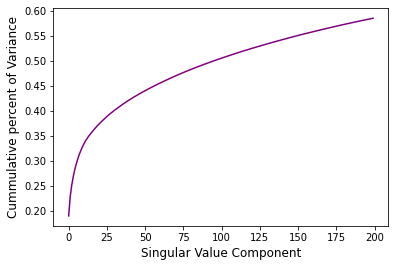

In [68]:
# plot variance
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained,'-',ms = 16,color = 'purple')
plt.xlabel('Singular Value Component',fontsize = 12)
plt.ylabel('Cummulative percent of Variance',fontsize=12)
plt.show()

In [69]:
latent_matrix_2_df.to_csv('/content/Database_Files/collaborative_based_latent_matrix.csv')

## Running a Content/Collaborative and hybrid cosine similarity.

In [70]:
test_anime_name = 'Doraemon (1979)'

In [71]:
# Taking latent vectors for selected movie from both content and collaborative based latent vector dataframes.
content_latent_vector = np.array(latent_matrix_1_df.loc[test_anime_name]).reshape(1,-1)
collaborative_latent_vector = np.array(latent_matrix_2_df.loc[test_anime_name]).reshape(1,-1)

In [72]:
score_1 = cosine_similarity(latent_matrix_1_df,content_latent_vector).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df,collaborative_latent_vector).reshape(-1)

In [73]:
hybrid = (score_1+score_2)/2

In [74]:
dictDF = {'content':score_1,
          'collaborative':score_2,
          'hybrid':hybrid}

In [75]:
similar = pd.DataFrame(dictDF,index = latent_matrix_1_df.index)

In [76]:
similar.sort_values('hybrid',ascending=False,inplace = True)


In [77]:
similar[1:].head(11)

,content,collaborative,hybrid
Level E,0.693047,0.767602,0.730324
Doraemon: The Day When I Was Born,0.767239,0.689156,0.728197
Dorami &amp; Doraemons: Space Land&#039;s Critical Event,0.748324,0.703756,0.726040
Sonic X,0.839310,0.570269,0.704789
Doraemon Movie 16: Nobita no Sousei Nikki,0.718291,0.669749,0.694020
Fairy Tail,0.637394,0.749257,0.693326
YAT Anshin! Uchuu Ryokou 2,0.715881,0.665204,0.690543
Oban Star-Racers,0.641157,0.733278,0.687218
Mazinkaiser,0.641162,0.727573,0.684367
MÄR,0.691623,0.673584,0.682604
